# Why do humans seem to learn so much faster than machine learning models? 
*Where we use the magic of word embeddings to illustrate we can exploit understanding of the world to train better machine learning models*

*The article, code and data can be [found on github](https://github.com/PaulHiemstra/wordembedding_magic)*

# Introduction
How come humans can learn how to drive a car in about 50 hours while a machine learning (ML) model needs the equivalent data of thousands of hours of driving? This massive difference is in my opinion caused by the fact that humans have an innate understanding of the world around them. If I drop an egg, I can predict that the egg will break as soon as it hits the ground. In addition, without ever having dropped a glass on the floor I can infer from the egg breaking that the glass will also probably break on impact. Translating this to a driving context: when I see another car on the road I can somewhat predict what the car will do by imagining what I would do given the situation. This *understanding* of our surrounding world and our ability to accurately *reason* outcomes given a specific situation gives us a massive edge on ML models.   

Strides have been made in enabling ML models to mimic the kind of understanding humans have. A great and frankly magical example are word embeddings. In this article I will pick apart a set of trained word embeddings, and explain why in my opinion they show a real understanding of the world we live in. In addition, I want to convey my absolute fascination that from a simple training scheme a subtle understanding of our world can emerge. 

# But what exactly are word embeddings? 
Word embeddings are a way to represent text data as numbers, needed if you want to feed the text into an ML model. Word embeddings represent each word using say 50 features. Words that are close together in this 50 dimensional space are similar in meaning, for example `apple` and `orange`. The challenge we face is how to construct these 50 features. 

Multiple approaches have been proposed, but in this article we focus on [Glove word embeddings](https://nlp.stanford.edu/projects/glove/). Glove word embeddings are derived from a co-occurence matrix of the words in a corpus. If words occur in the same textual context, Glove assumes they are similar in meaning. This already presents the first hint that word embeddings learn an understanding of the corpus they train on. 

If in a given context a lot of fruits are used, the word embeddings will know `apple` would fit in that place. This works even if the training set never used the word `apple` in that specific context. Word embeddings allow training to be more flexible via the representation of the world the word embeddings learn. 

# Loading pre-trained Glove Word embeddings
To really dig into the power of word embeddings we are going to load some pretrained Glove word embeddings and explore them. I use [the 50 feature word embeddings](https://www.kaggle.com/watts2/glove6b50dtxt):

In [1]:
import numpy as np
import pandas as pd

def read_glove2dict(filepath):
    word_embedding_dict = dict()
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()  # Nice little trick to unpack the word and following embedding features
            values = np.array(vector, dtype=np.float32)
            word_embedding_dict[word] = values / np.linalg.norm(values)
    return word_embedding_dict

word_embedding_dict = read_glove2dict('data/glove.6B.50d.txt')
word_embedding_dict['the'][:5]

array([ 0.08414142,  0.0502594 , -0.08301819,  0.02449763,  0.06950121],
      dtype=float32)

The word embeddings are stored as a space separated text file where the first entry is the word, and the other entries the embedding values. The function above simply reads this into a big dictionary where the word is the key, and the embedding values are the value. 

# Simple reasoning with word embeddings
The simplest form of reasoning is how similar words are to each other in the word embedding feature space. We are now faced with the challenge of visualising a 50d embedding space, which is virtually impossible. For visualisation purposes, we reduce the 50d embedding space to just 2 dimensions using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis). In the figure below we show a few words that fall into categories ranging from animals to fruits:

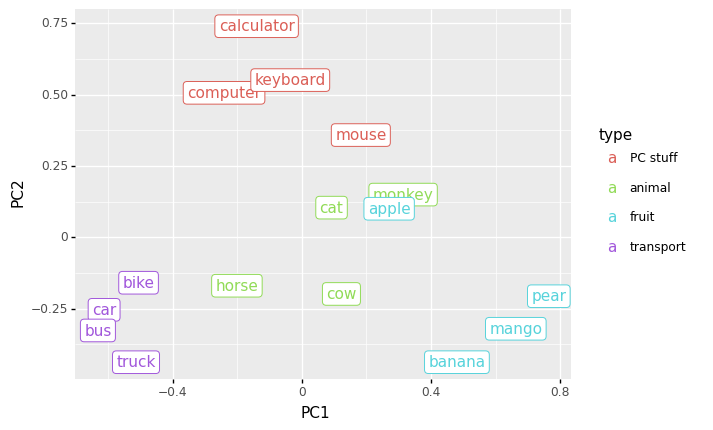

<ggplot: (8774325437693)>

In [2]:
from sklearn.decomposition import PCA
from plotnine import *

words = ['horse', 'cow', 'monkey', 'cat', 'apple', 'banana', 'pear', 'mango',
         'car', 'bus', 'truck', 'bike', 'computer', 'calculator', 'keyboard', 'mouse']

plot_word = pd.DataFrame(PCA(n_components=2).fit_transform([word_embedding_dict[w] for w in words]), 
                         columns=['PC1', 'PC2'])

plot_word['word'] = words
plot_word['type'] = list(pd.Series(['animal', 'fruit', 'transport', 'PC stuff']).repeat(4))

(
    ggplot(plot_word, aes(x='PC1', y='PC2')) + 
      geom_point(aes(color='type')) + 
      geom_label(aes(label='word', color='type'))
)

The patterns that emerge here make sense:

- The different categories cluster together in the embedding space. 
- `mouse` is inbetween the `PC stuff` and `animal` categories.
- `horse` is inbetween the `animal` and `transport` categories. 

What is amazing to me is the subtlety of the understanding that is captured. A `mouse` can be both and animal and a PC peripheral. But the magic does not end here, the rabbit hole is a lot deeper still. 

# More complex reasoning: relations
Beyond looking at words individually, we can look at relations between words. For example, the vector between the word `france` and `paris` describe the relation `capital of`. Lets draw the vectors of a number of country-capital pairs:

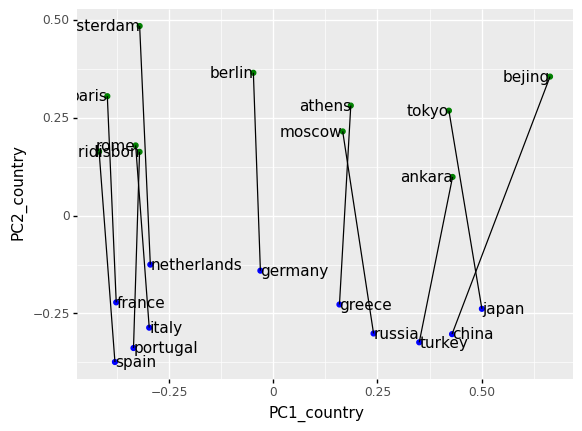

<ggplot: (8774320419521)>

In [3]:
country_capitals = ['china', 'bejing', 'russia', 'moscow', 'japan', 'tokyo', 
                    'turkey', 'ankara', 'spain', 'madrid', 'france', 'paris',
                    'portugal', 'lisbon', 'greece', 'athens', 'italy', 'rome',
                    'netherlands', 'amsterdam', 'germany', 'berlin']
plot_word = pd.DataFrame(PCA(n_components=2).fit_transform([word_embedding_dict[w] for w in country_capitals]), 
                         columns=['PC1', 'PC2'])
plot_word['word'] = country_capitals
plot_word['concept'] = pd.Series(['country', 'capital'] * int(len(plot_word) / 2))
plot_word['country'] = list(pd.Series(['china', 'russia', 'japan', 'turkey', 'spain', 'france', 'portugal', 'greece', 'italy', 'netherlands', 'germany']).repeat(2))
plot_word = plot_word.pivot(index='country', columns='concept')  # Needed for plotting in plotnine
plot_word.columns = ['_'.join(col).strip() for col in plot_word.columns.values]

(
    ggplot(plot_word) + 
      geom_point(aes(x='PC1_country', y='PC2_country'), color='blue') + 
      geom_text(aes(x='PC1_country', y='PC2_country', label='word_country'), ha='left') + 
      geom_point(aes(x='PC1_capital', y='PC2_capital'), color='green') + 
      geom_text(aes(x='PC1_capital', y='PC2_capital', label='word_capital'), ha='right') +
      geom_segment(aes(x = 'PC1_country', xend='PC1_capital', y='PC2_country', yend='PC2_capital'))
)

The vector between the countries at the bottom and the capitals at the top are all roughly similar. This shows that the word embeddings learned the relation `capital of`. I am truly astounded that from simply looking at which words occur close to each other in the input text a relation as complex as `capital of` emerges. 

But the voodoo does not end here. With these word embeddings in hand, we can use vector calculus to [perform some truly amazing deductions](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/):

In [4]:
from scipy.spatial import cKDTree

# Represent the embeddings as a matrix, needed for search with cKDTree
word_indices = pd.Series(list(word_embedding_dict.keys()))
embedding_matrix = np.array(list(word_embedding_dict.values()))

# Perform some vector magic with embeddings
find_capital_poland = word_embedding_dict['paris'] - word_embedding_dict['france'] + word_embedding_dict['poland']
closest_word = cKDTree(embedding_matrix).query(find_capital_poland, k=1)
word_indices[closest_word[1]]

'warsaw'

This outcome truly blows me away (you probably figured out by now I like word embeddings :)). We can take `paris`, subtract its nation from it and add a new nation (`poland`) to get to the capital of that nation: `warsaw`. This really shows intricate understanding that is captured by the word embeddings. 

# Wrapping up
I hope by now I have convinced you word embeddings really gain an understanding of the world that is described by the corpus. This understanding can be leveraged by the ML models that take these word embeddings as input. I think ML models gaining an understanding of the world we live in is a crucial component in building better ML models. New ML concepts such as [transformers](https://en.wikipedia.org/wiki/GPT-3) show even more promise in taking this understanding to the next level. 

As a final note, what really is 'understanding'. One might argue word embeddings do not really represent understanding in the human sense. That it is just a very complicated party trick hidden by layers of math. Then again, is our own understanding of the world not also an emergent property of a really large amount of neurons? 

Do you like word embeddings, are you just as amazed as I am? Or are you more skeptical? Let me know!